# Tutorial on the Reproduction of selected Articles

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/dehe1011/QuantumDNA-notebooks/blob/main/tutorials/Reproduce.ipynb)

In [2]:
%load_ext autoreload
%autoreload 2

# Flags
save = False          # Set to True to enable saving results (currently unused in this script)
verbose = False       # Set to True to enable detailed logging

## Setup

In [3]:
import os
import importlib.util

# Check if the 'qDNA' package is already installed
qDNA_installed = importlib.util.find_spec('qDNA') is not None

if qDNA_installed:
    if verbose:
        print("Package 'qDNA' is already installed.")
        # Optional: Uncomment the next line to display qDNA package information
        # %pip show qDNA
else:
    # Install 'qDNA' package if not installed
    %pip install qDNA
    if verbose:
        print("Successfully installed the 'qDNA' package.")

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from qDNA import ROOT_DIR as ROOT_DIR_QDNA

# Use the current working directory as the root
ROOT_DIR = os.getcwd()

# Define directories for data and figures
DATA_DIR = os.path.join(ROOT_DIR, "data", "my_geometries")
FIG_DIR = os.path.join(ROOT_DIR_QDNA, "qDNA", "data", "figures_tutorials")

# Ensure the directories exist (create them if they don't already exist)
os.makedirs(DATA_DIR, exist_ok=True)

SAVE_DIR = os.path.join(os.getcwd(), "my_figures")  # Directory for plots 
if save:
    os.makedirs(os.path.join(os.getcwd(), SAVE_DIR), exist_ok=True)

if verbose:
    # Print the status of the directories for debugging purposes
    print(f"Data directory: '{DATA_DIR}' is ready.")
    print(f"Figures directory: '{FIG_DIR}' is ready.")
    print(f"Save directory: '{SAVE_DIR}' is ready.")

## Giese 1999 and Simserides 2014

[1] B. Giese et al., Angew. Chem. Int. Ed. **38**, 996 (1999)

[2] C. Simserides, Chemical Physics **440**, 31 (2014)

In [5]:
# Giese experiment: eta = 1.7, beta = 0.07

ratio_list = []
for num_steps in np.arange(1, 9):
    bridge = 'TT' + 'GTT' * (num_steps-1)
    upper_strand = 'ACGCACGTCGCATAATATTAC' + 'G' + bridge + 'GGG' + 'TATTATATTACGC'
    tb_ham = TB_Ham(DNA_Seq(upper_strand, 'WM'), description='1P', particles=['hole'], unit='rad/fs', relaxation=False, source='Simserides2014')
    
    init_site = '(0, 21)'
    average_pop_donor = tb_ham.get_average_pop(init_site, init_site)['hole']
    
    acceptor_sites = [f'(0, {21+len(bridge)+1})', f'(0, {21+len(bridge)+2})',  f'(0, {21+len(bridge)+3})']
    average_pop_acceptor = 0
    for acceptor_site in acceptor_sites:
        average_pop_acceptor += tb_ham.get_average_pop(init_site, acceptor_site)['hole']

    ratio = average_pop_acceptor / average_pop_donor 
    ratio_list.append(ratio)

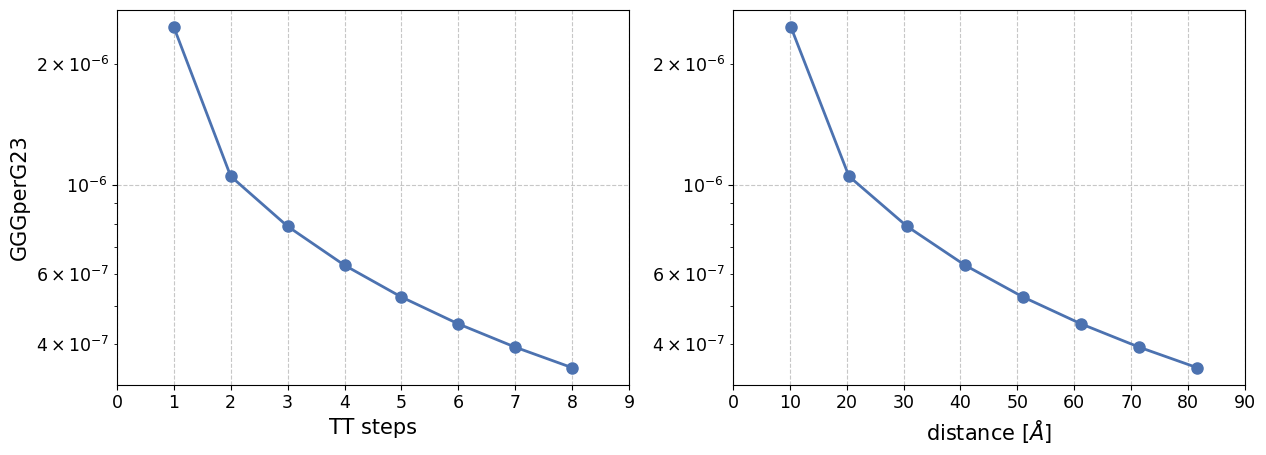

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

ax[0].plot(np.arange(1, 9), ratio_list, 'o-')
ax[0].set_yscale('log')
ax[0].set_xlim(0, 9)
ax[0].set_xlabel(r'TT steps')
ax[0].set_ylabel('GGGperG23')

ax[1].plot(np.arange(1, 9) * 3 * 3.4, ratio_list, 'o-')
ax[1].set_yscale('log')
ax[1].set_xlim(0, 90)
ax[1].set_xlabel(r'distance [$\AA$]')
plt.show()

## Giese 2001 and Simserides 2014

[1] B. Giese, Nature **412**, 318 (2001)

[2] C. Simserides, Chemical Physics **440**, 31 (2014)

In [7]:
# experiment: beta = 0.6 
# theory: beta = 0.8, beta = 0.07

from qDNA import TB_Ham, DNA_Seq, get_pop_fourier

def calc_difference(upper_strand, t):
    """ t in fs. """
    tb_ham = TB_Ham(DNA_Seq(upper_strand, 'WM'), description='1P', particles=['hole'], unit='rad/fs', relaxation=False, source='Simserides2014')
    difference = 0
    acceptor_sites = [f'(0, {len(bridge)+1})', f'(0, {len(bridge)+2})', f'(0, {len(bridge)+3})']
    for acceptor_site in acceptor_sites:
        amplitudes_dict, frequencies_dict, average_pop_dict = tb_ham.get_fourier('(0, 0)', acceptor_site, ["amplitude", "frequency", "average_pop"])
        amplitudes, frequencies, average_pop = amplitudes_dict['hole'], frequencies_dict['hole'], average_pop_dict['hole']
        difference += average_pop - get_pop_fourier(t, average_pop, amplitudes, frequencies)
    return average_pop, difference


def calc_t_mean(upper_strand, t_max, t_min=0, t_step=1): 
    for t in range(t_min, t_max, t_step):
        average_pop, difference = calc_difference(upper_strand, t)
        if difference <= 0:
            return average_pop, t
    return average_pop, f"Mean population not reached in {t_max} fs"

t_mean_list, average_pop_list, transfer_rate_list = [], [], []
t_min_list = [2000, 32000, 225000, 250000, 140000, 3000, 0, 1000, 4000, 1000, 0, 1000, 4000, 3000, 3000, 1000]
t_steps_list = [1, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

for i, num_T in enumerate(np.arange(1,17)):
    bridge = 'T' * num_T
    upper_strand = 'G' + bridge + 'GGG' + 'TATTATATTACGC'
    average_pop, t_mean = calc_t_mean(upper_strand, 10_000_000, t_min=t_min_list[i], t_step=t_steps_list[i])
    average_pop_list.append(average_pop)
    t_mean_list.append(t_mean)
    transfer_rate_list.append(average_pop/t_mean)

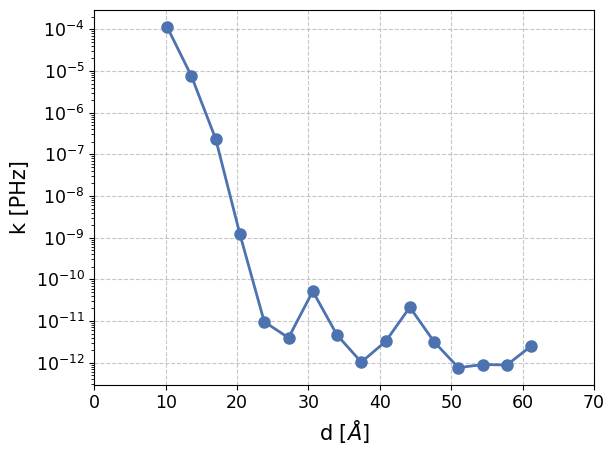

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(np.arange(3, 19)*3.4, transfer_rate_list, 'o-')
ax.set_yscale('log')
ax.set_xlim(0, 70)
ax.set_xlabel(r'd [$\AA$]')
ax.set_ylabel('k [PHz]')
plt.show()

## Bittner 2006 & 2007

[1] E. Bittner, The Journal of Chemical Physics **125**, 094909 (2006)

[2] E. Bittner, Journal of Photochemistry and Photobiology A: Chemistry **190**, 328 (2007)

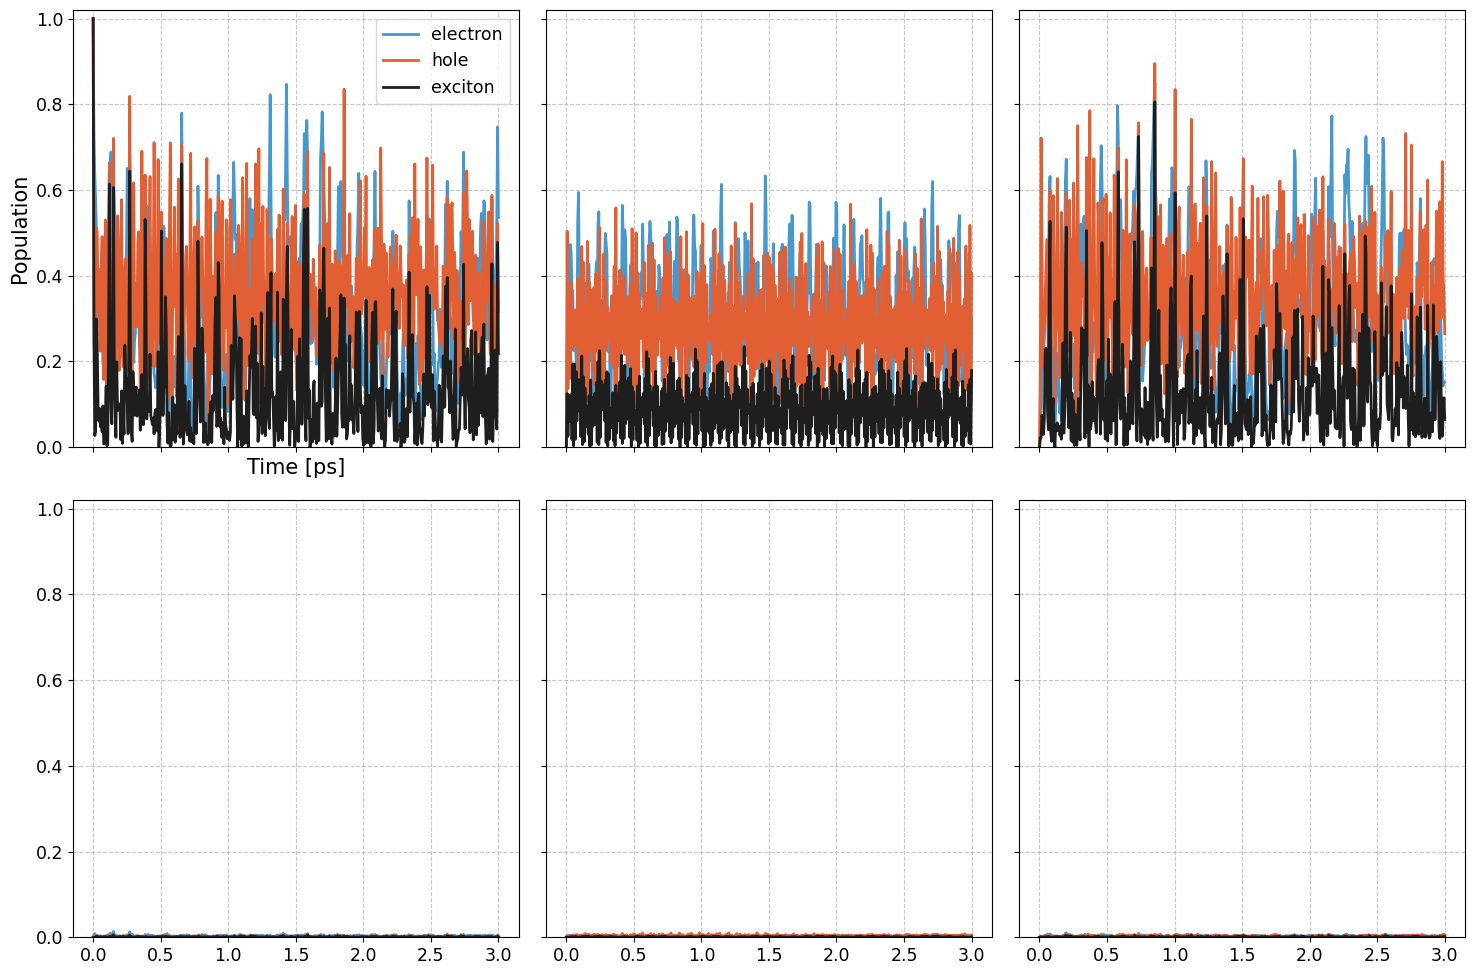

In [4]:
from qDNA import get_me_solver, plot_pops

upper_strand = 'AAA'
kwargs = dict(source='Bittner2007', unit='eV', relaxation=False, coulomb_interaction=2.5, exchange_interaction=1)

me_solver = get_me_solver(upper_strand, 'ELM', **kwargs)

fig, ax = plot_pops(me_solver)

## Mantela 2023

[1] M. Mantela, Phys. Chem. Chem. Phys. **25**, 7750 (2023)

In [5]:
from qDNA import load_xyz, Base, BasePair, Dimer

xyz_identifier, xyz_data = load_xyz("A1", os.path.join(DATA_DIR, "Mantela"))
base1 = Base(xyz_identifier, xyz_data)

xyz_identifier, xyz_data = load_xyz("c1'", os.path.join(DATA_DIR, "Mantela"))
base2 = Base(xyz_identifier, xyz_data)

xyz_identifier, xyz_data = load_xyz("A2", os.path.join(DATA_DIR, "Mantela"))
base3 = Base(xyz_identifier, xyz_data)

xyz_identifier, xyz_data = load_xyz("c2'", os.path.join(DATA_DIR, "Mantela"))
base4 = Base(xyz_identifier, xyz_data)

basepair1 = BasePair(base1, base2)
basepair2 = BasePair(base3, base4)

dimer = Dimer(basepair1, basepair2)

In [6]:
print("TB parameters")
print("-------------------------------")
print(f"E_HOMO1: {dimer.molecule1.E_HOMO}")
print(f"E_LUMO1: {dimer.molecule1.E_LUMO}")
print("-------------------------------")
print(f"E_HOMO2: {dimer.molecule2.E_HOMO}")
print(f"E_LUMO2: {dimer.molecule2.E_LUMO}")
print("-------------------------------")
print(f"t_HOMO: {dimer.t_HOMO}")
print(f"t_LUMO: {dimer.t_LUMO}")

TB parameters
-------------------------------
E_HOMO1: -8.429037928082415
E_LUMO1: -4.432891842321037
-------------------------------
E_HOMO2: -8.430148205528646
E_LUMO2: -4.43267272482506
-------------------------------
t_HOMO: -0.035940257425427
t_LUMO: -0.09015171853086595
